## 베트남 음식 분류하기 -  [데이터](https://www.kaggle.com/datasets/quandang/vietnamese-foods)

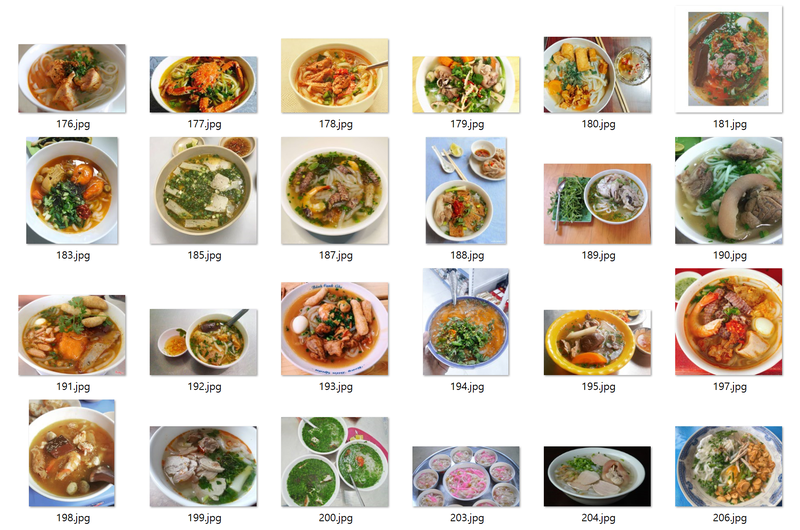

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# training set과 test set의 모든 이미지 파일에 대해서,
# jpg image header가 포함되지 않은 (jpg의 파일 구조에 어긋나는) 파일들을 삭제해줍니다.

data_path = '/aiffel/aiffel/model-fit/data/30vnfoods/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'

for path in [train_path, test_path]:
    classes = os.listdir(path)

    for food in classes:
        food_path = os.path.join(path, food)
        images = os.listdir(food_path)
        
        for image in images:
            with open(os.path.join(food_path, image), 'rb') as f:
                bytes = f.read()
            if bytes[:3] != b'\xff\xd8\xff':
                print(os.path.join(food_path, image))
                os.remove(os.path.join(food_path, image))

In [3]:
classes = os.listdir(train_path)
train_length = 0

for food in classes:
    food_path = os.path.join(train_path, food)
    images = os.listdir(food_path)
    
    train_length += len(images)

print('training data의 개수: '+str(train_length))

training data의 개수: 9775


- 문제1: dataloader 구현하기
    - 주어진 함수들과 TensorFlow Data API를 이용해서 dataloader를 구현해야 합니다.
- 문제2: 모델 구현하기
    - EfficientNetB0 backbone과 Dense 레이어를 결합하여 모델을 구현해야 합니다.
    - 다른 모델을 사용하여 backbone을 만들어 보아도 좋습니다.
- 문제3: custom trainer 구현하기
    - TensorFlow GradientTape를 이용해서 custom trainer 클래스를 구현해야 합니다.
    - 학습이 진행되면서 training accuracy가 점차 증가할 수 있도록 만들어 보세요.

In [4]:
# 문제1: dataloader 구현하기

def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    이미지 크기를 (224, 224)로 맞춰주세요.
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(1)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    TensorFlow Dataset 객체를 생성하고 process_path 함수로 이미지와 라벨을 묶은 다음,
    prepare_for_training 함수로 batch가 적용된 Dataset 객체를 만들어주세요.
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

In [5]:
#문제2: 모델 구현하기

from tensorflow.keras.applications import EfficientNetB0

class Model(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 개수만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=10, freeze=False):
        super(Model, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

In [6]:
# 문제3: custom trainer 구현하기

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch+1,))
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

In [7]:
# 모델 학습 코드

train_path = "/aiffel/aiffel/model-fit/data/30vnfoods/Train"

epoch = 5
batch = 64

model = Model(num_classes=10)
dataset = load_data(data_path=train_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                epochs=epoch,
                batch=batch,
#                 ds_length=train_length,
                loss_fn=loss_function,
                optimizer=optimizer)

trainer.train(train_dataset=dataset,
            train_metric=train_acc_metric)


Start of epoch 1
Training loss (for one batch) at step 0: 4.1211
Seen so far: 64 samples
0.078125
Training loss (for one batch) at step 5: 2.5322
Seen so far: 384 samples
0.19270833
Training loss (for one batch) at step 10: 2.0708
Seen so far: 704 samples
0.2784091
Training loss (for one batch) at step 15: 1.5314
Seen so far: 1024 samples
0.3671875
Training loss (for one batch) at step 20: 1.3017
Seen so far: 1344 samples
0.43229166
Training loss (for one batch) at step 25: 1.0243
Seen so far: 1664 samples
0.4825721
Training loss (for one batch) at step 30: 0.9658
Seen so far: 1984 samples
0.51965725
Training loss (for one batch) at step 35: 0.7580
Seen so far: 2304 samples
0.5416667
Training loss (for one batch) at step 40: 1.0274
Seen so far: 2624 samples
0.56669205
Training loss (for one batch) at step 45: 0.8338
Seen so far: 2944 samples
0.5852581
Training loss (for one batch) at step 50: 0.5377
Seen so far: 3264 samples
0.6041667
Training loss (for one batch) at step 55: 0.6441
S

In [8]:
# 모델 테스트 코드
test_ds = load_data(data_path=test_path)

for step_train, (x_batch_train, y_batch_train) in enumerate(test_ds.take(10)):
    prediction = model(x_batch_train)
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))

28/32
26/32
23/32
27/32
31/32
28/32
26/32
29/32
23/32
29/32
